In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights, ViT_B_16_Weights

import os
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import glob
import copy
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
from thop import profile # For FLOPs calculation



In [4]:
# --- Hyperparameters and Configuration ---

# Set device (GPU or CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Model parameters
LEARNING_RATE = 0.001
BATCH_SIZE = 32 # Small batch size for mock data; increase for real dataset
NUM_EPOCHS = 35 # Increase for real training
IMG_SIZE = 224 # Input size for models like ResNet/EfficientNet
PATIENCE = 5 # For early stopping

# Data paths (pointing to our mock data)
TRAIN_REAL_DIR = "/kaggle/input/fake-real/data/real_cifake_images"
TRAIN_FAKE_DIR = "/kaggle/input/fake-real/data/fake_cifake_images"
TEST_DIR = "/kaggle/input/fake-real/data/test"

# Model save paths
RESNET_PATH = "/kaggle/input/models-weightsss/best_resnet.pth"
EFFICIENTNET_PATH = "/kaggle/input/models-weightsss/best_efficientnet.pth"
CUSTOM_CNN_PATH = "/kaggle/input/models-weightsss/best_custom_cnn.pth"
VIT_PATH = "best_vit.pth"

Using device: cuda


In [5]:
class DeepfakeTrainDataset(Dataset):
    """Custom Dataset for loading real and fake training images."""
    def __init__(self, real_dir, fake_dir, transform=None):
        self.transform = transform
        self.image_files = []

        # Load real images (label 0)
        for filename in glob.glob(os.path.join(real_dir, "*.png")):
            self.image_files.append((filename, 0.0))

        # Load fake images (label 1)
        for filename in glob.glob(os.path.join(fake_dir, "*.png")):
            self.image_files.append((filename, 1.0))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image and label if loading fails
            image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color="black")
            label = 0.0 # Or handle as you see fit

        if self.transform:
            image = self.transform(image)

        # We need label as a float tensor for BCEWithLogitsLoss
        return image, torch.tensor(label, dtype=torch.float32)


class DeepfakeTestDataset(Dataset):
    """Custom Dataset for loading test images."""
    def __init__(self, test_dir, transform=None):
        self.transform = transform
        self.image_files = glob.glob(os.path.join(test_dir, "*.png"))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        filename = os.path.basename(img_path)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading test image {img_path}: {e}")
            image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color="black")

        if self.transform:
            image = self.transform(image)

        return image, filename

In [6]:
# --- Data Transforms ---
# Define normalization constants (standard for ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Data augmentation for training to prevent overfitting
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    normalize
])

# No augmentation for validation and testing
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize
])


In [7]:
# --- Create DataLoaders ---

# 1. Create the full training dataset
full_dataset = DeepfakeTrainDataset(TRAIN_REAL_DIR, TRAIN_FAKE_DIR, transform=train_transforms)

# 2. Split into training and validation sets (e.g., 80% train, 20% val)
total_size = len(full_dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size

# Check if dataset is large enough to split
if train_size > 0 and val_size > 0:
    train_dataset, val_dataset_with_aug = random_split(full_dataset, [train_size, val_size])
    
    # IMPORTANT: We must apply validation transforms (no aug) to the validation set
    # We create a new Dataset object for validation using the indices from the split
    # This is a bit of a workaround but ensures no data augmentation leaks into validation
    val_dataset = DeepfakeTrainDataset(TRAIN_REAL_DIR, TRAIN_FAKE_DIR, transform=val_test_transforms)
    val_dataset.image_files = [full_dataset.image_files[i] for i in val_dataset_with_aug.indices]
else:
    print("Dataset too small to split. Using full dataset for both training and validation.")
    # This is not ideal, but necessary for our tiny mock dataset
    train_dataset = full_dataset
    val_dataset = DeepfakeTrainDataset(TRAIN_REAL_DIR, TRAIN_FAKE_DIR, transform=val_test_transforms)


print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# 4. Create Test DataLoader
test_dataset = DeepfakeTestDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Test images: {len(test_dataset)}")

Total training images: 1600
Total validation images: 400
Test images: 500


In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, patience, model_save_path):
    """
    Main training and validation loop with early stopping.
    """
    
    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats(DEVICE)
        
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}
    
    best_model_state = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # --- Training Phase ---
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE).unsqueeze(1) # Match shape for BCEWithLogitsLoss [batch_size, 1]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects += torch.sum(preds == (labels > 0.5))
            train_total += labels.size(0)

        epoch_train_loss = running_loss / train_total
        epoch_train_acc = running_corrects.double() / train_total
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')

        # --- Validation Phase ---
        model.eval()   # Set model to evaluate mode
        running_val_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE).unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs) > 0.5
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        # Calculate validation metrics
        if len(all_labels) > 0:
            val_total = len(all_labels)
            epoch_val_loss = running_val_loss / val_total
            
            # Convert lists of arrays to a single flat array for sklearn
            all_labels = np.array(all_labels).flatten()
            all_preds = np.array(all_preds).flatten()

            epoch_val_acc = accuracy_score(all_labels, all_preds)
            # Use zero_division=0 to handle cases with no positive predictions/labels
            epoch_val_precision = precision_score(all_labels, all_preds, zero_division=0)
            epoch_val_recall = recall_score(all_labels, all_preds, zero_division=0)
            epoch_val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        else:
            print("Validation set is empty. Skipping metrics.")
            epoch_val_loss = 0.0
            epoch_val_acc = 0.0
            epoch_val_precision = 0.0
            epoch_val_recall = 0.0
            epoch_val_f1 = 0.0
            
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_precision'].append(epoch_val_precision)
        history['val_recall'].append(epoch_val_recall)
        history['val_f1'].append(epoch_val_f1)

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        print(f'Val Precision: {epoch_val_precision:.4f} Recall: {epoch_val_recall:.4f} F1: {epoch_val_f1:.4f}')

        # --- Early Stopping Check ---
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, model_save_path)
            model_size_mb = os.path.getsize(model_save_path) / (1024 * 1024)
            print(f"New best model saved to {model_save_path} (Size: {model_size_mb:.2f} MB)")
            early_stopping_counter = 0
        else:
            if early_stopping_counter >= patience:
                print("Early stopping triggered")
                break

    end_time = time.time()
    total_duration_sec = end_time - start_time
    print(f'\nTraining complete in {total_duration_sec // 60:.0f}m {total_duration_sec % 60:.0f}s')
    print(f'Best val Loss: {best_val_loss:4f}')
    
    if DEVICE == "cuda":
        peak_mem_mb = torch.cuda.max_memory_allocated(DEVICE) / (1024 * 1024)
        print(f'Peak GPU memory allocated during training: {peak_mem_mb:.2f} MB')
    
    # Load best model weights back
    model.load_state_dict(torch.load(model_save_path))
    
    return history, total_duration_sec


In [9]:
def plot_history(history, title):
    """Plots training and validation metrics."""
    plt.figure(figsize=(12, 8))
    
    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} - Loss')

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} - Accuracy')

    # Plot Precision & Recall
    plt.subplot(2, 2, 3)
    plt.plot(history['val_precision'], label='Val Precision')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.legend()
    plt.title(f'{title} - Precision & Recall')

    # Plot F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(history['val_f1'], label='Val F1-Score')
    plt.legend()
    plt.title(f'{title} - F1-Score')

    plt.tight_layout()
    plt.show()

--- Training Model 4: Vision Transformer (ViT-B/16) ---


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 188MB/s]  


ViT-B/16: 11.29 GFLOPs, 57.30 MParams
Epoch 1/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Train Loss: 0.5816 Acc: 0.7031


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.08it/s]


Val Loss: 0.4994 Acc: 0.7975
Val Precision: 0.8212 Recall: 0.7500 F1: 0.7840
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 2/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Train Loss: 0.4445 Acc: 0.8275


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.25it/s]


Val Loss: 0.4269 Acc: 0.8325
Val Precision: 0.8449 Recall: 0.8061 F1: 0.8251
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 3/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Train Loss: 0.3924 Acc: 0.8550


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.22it/s]


Val Loss: 0.3896 Acc: 0.8650
Val Precision: 0.8698 Recall: 0.8520 F1: 0.8608
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 4/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


Train Loss: 0.3568 Acc: 0.8738


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.18it/s]


Val Loss: 0.3645 Acc: 0.8725
Val Precision: 0.8502 Recall: 0.8980 F1: 0.8734
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 5/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Train Loss: 0.3272 Acc: 0.8844


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.18it/s]


Val Loss: 0.3449 Acc: 0.8725
Val Precision: 0.8436 Recall: 0.9082 F1: 0.8747
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 6/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Train Loss: 0.3033 Acc: 0.8950


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


Val Loss: 0.3409 Acc: 0.8650
Val Precision: 0.8817 Recall: 0.8367 F1: 0.8586
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 7/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Train Loss: 0.2897 Acc: 0.8962


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


Val Loss: 0.3233 Acc: 0.8725
Val Precision: 0.8718 Recall: 0.8673 F1: 0.8696
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 8/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.2843 Acc: 0.8956


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.13it/s]


Val Loss: 0.3177 Acc: 0.8700
Val Precision: 0.8871 Recall: 0.8418 F1: 0.8639
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 9/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.2638 Acc: 0.9106


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]


Val Loss: 0.3103 Acc: 0.8850
Val Precision: 0.8788 Recall: 0.8878 F1: 0.8832
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 10/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.2690 Acc: 0.9012


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.09it/s]


Val Loss: 0.3043 Acc: 0.8725
Val Precision: 0.8469 Recall: 0.9031 F1: 0.8741
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 11/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.2492 Acc: 0.9175


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.3014 Acc: 0.8800
Val Precision: 0.8854 Recall: 0.8673 F1: 0.8763
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 12/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.2404 Acc: 0.9169


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


Val Loss: 0.2963 Acc: 0.8825
Val Precision: 0.8942 Recall: 0.8622 F1: 0.8779
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 13/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.2319 Acc: 0.9206


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.2932 Acc: 0.8900
Val Precision: 0.9000 Recall: 0.8724 F1: 0.8860
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 14/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.2245 Acc: 0.9213


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.06it/s]


Val Loss: 0.2890 Acc: 0.8850
Val Precision: 0.8906 Recall: 0.8724 F1: 0.8814
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 15/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.2219 Acc: 0.9231


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.2877 Acc: 0.8900
Val Precision: 0.8918 Recall: 0.8827 F1: 0.8872
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 16/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.2179 Acc: 0.9238


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


Val Loss: 0.2847 Acc: 0.8975
Val Precision: 0.8934 Recall: 0.8980 F1: 0.8957
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 17/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.2167 Acc: 0.9256


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.08it/s]


Val Loss: 0.2816 Acc: 0.9075
Val Precision: 0.8995 Recall: 0.9133 F1: 0.9063
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 18/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.2106 Acc: 0.9256


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s]


Val Loss: 0.2846 Acc: 0.8875
Val Precision: 0.9081 Recall: 0.8571 F1: 0.8819
Epoch 19/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.2087 Acc: 0.9269


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.2779 Acc: 0.9050
Val Precision: 0.9031 Recall: 0.9031 F1: 0.9031
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 20/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.2041 Acc: 0.9300


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s]


Val Loss: 0.2780 Acc: 0.8950
Val Precision: 0.9096 Recall: 0.8724 F1: 0.8906
Epoch 21/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.1975 Acc: 0.9287


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.06it/s]


Val Loss: 0.2781 Acc: 0.8975
Val Precision: 0.9101 Recall: 0.8776 F1: 0.8935
Epoch 22/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.1914 Acc: 0.9325


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s]


Val Loss: 0.2863 Acc: 0.8825
Val Precision: 0.9116 Recall: 0.8418 F1: 0.8753
Epoch 23/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.1903 Acc: 0.9300


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.09it/s]


Val Loss: 0.2807 Acc: 0.8925
Val Precision: 0.9091 Recall: 0.8673 F1: 0.8877
Epoch 24/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.1890 Acc: 0.9363


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.06it/s]


Val Loss: 0.2761 Acc: 0.9000
Val Precision: 0.9105 Recall: 0.8827 F1: 0.8964
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 25/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.1882 Acc: 0.9287


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.05it/s]


Val Loss: 0.2693 Acc: 0.9100
Val Precision: 0.9000 Recall: 0.9184 F1: 0.9091
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 26/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.1823 Acc: 0.9400


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.09it/s]


Val Loss: 0.2691 Acc: 0.9075
Val Precision: 0.8995 Recall: 0.9133 F1: 0.9063
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 27/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.1753 Acc: 0.9369


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.2688 Acc: 0.9050
Val Precision: 0.8990 Recall: 0.9082 F1: 0.9036
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 28/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.1737 Acc: 0.9394


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.2699 Acc: 0.9025
Val Precision: 0.8985 Recall: 0.9031 F1: 0.9008
Epoch 29/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.1764 Acc: 0.9406


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


Val Loss: 0.2687 Acc: 0.9050
Val Precision: 0.8990 Recall: 0.9082 F1: 0.9036
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 30/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.1783 Acc: 0.9425


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.07it/s]


Val Loss: 0.2650 Acc: 0.9125
Val Precision: 0.9045 Recall: 0.9184 F1: 0.9114
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 31/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.1685 Acc: 0.9444


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.13it/s]


Val Loss: 0.2641 Acc: 0.9075
Val Precision: 0.8995 Recall: 0.9133 F1: 0.9063
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 32/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.1819 Acc: 0.9331


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s]


Val Loss: 0.2608 Acc: 0.9100
Val Precision: 0.9000 Recall: 0.9184 F1: 0.9091
New best model saved to best_vit.pth (Size: 327.39 MB)
Epoch 33/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.1707 Acc: 0.9437


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.2621 Acc: 0.9150
Val Precision: 0.9050 Recall: 0.9235 F1: 0.9141
Epoch 34/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Train Loss: 0.1662 Acc: 0.9463


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.2622 Acc: 0.9125
Val Precision: 0.9045 Recall: 0.9184 F1: 0.9114
Epoch 35/35
----------


Training: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Train Loss: 0.1711 Acc: 0.9394


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Val Loss: 0.2577 Acc: 0.9125
Val Precision: 0.9045 Recall: 0.9184 F1: 0.9114
New best model saved to best_vit.pth (Size: 327.39 MB)

Training complete in 8m 28s
Best val Loss: 0.257706
Peak GPU memory allocated during training: 1009.17 MB


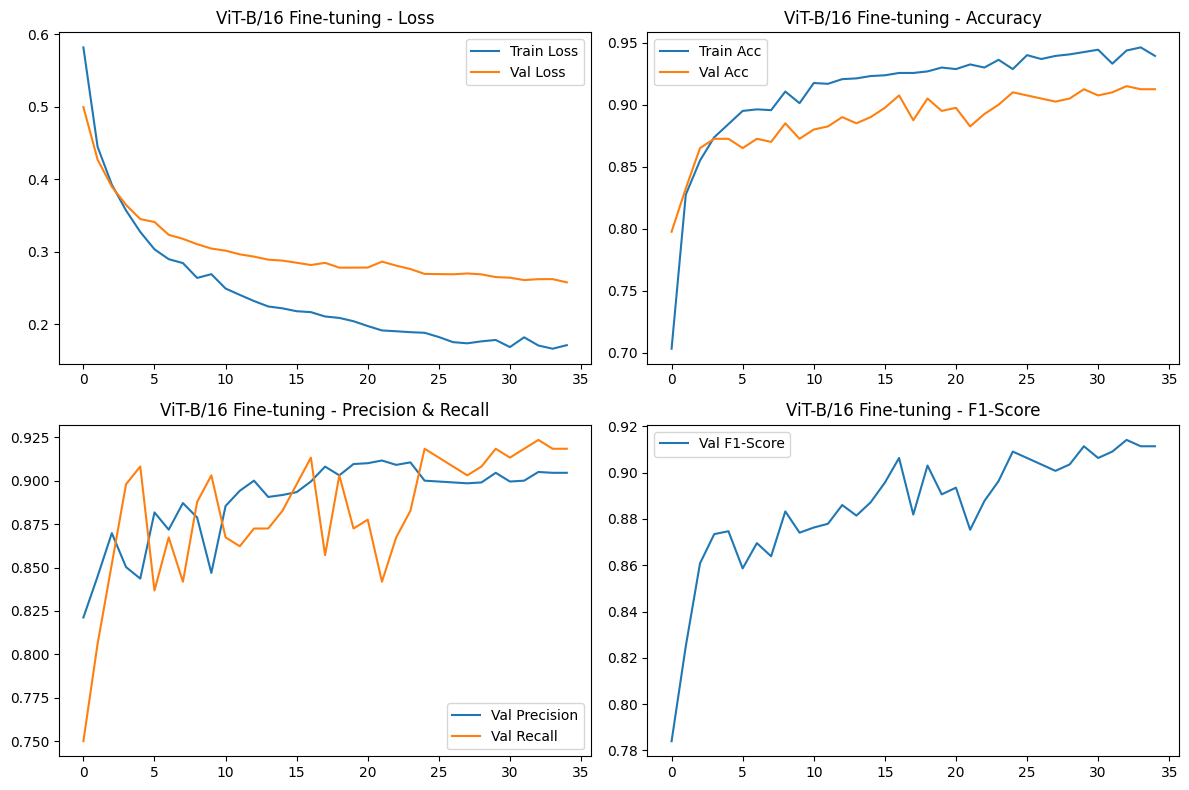

In [10]:
print("--- Training Model 4: Vision Transformer (ViT-B/16) ---")

# 1. Load pre-trained model
model_vit = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# 2. Freeze all parameters
for param in model_vit.parameters():
    param.requires_grad = False

# 3. Replace the final layer (head)
# The ViT's classification head is model.heads.head
in_features = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(in_features, 1)

# 4. Move model to device
model_vit = model_vit.to(DEVICE)

# 5. Calculate FLOPs and Params
try:
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    flops, params = profile(model_vit, inputs=(dummy_input, ), verbose=False)
    print(f"ViT-B/16: {flops/1e9:.2f} GFLOPs, {params/1e6:.2f} MParams")
except Exception as e:
    print(f"Could not calculate FLOPs for ViT-B/16: {e}")

# 6. Define Loss and Optimizer
# We only optimize the parameters of the new final head
criterion = nn.BCEWithLogitsLoss()
optimizer_vit = optim.Adam(model_vit.heads.parameters(), lr=LEARNING_RATE)

# 7. Train the model
vit_history, vit_time = train_model(model_vit, criterion, optimizer_vit, train_loader, val_loader, 
                                    num_epochs=NUM_EPOCHS, patience=PATIENCE, model_save_path=VIT_PATH)

# 8. Plot history
plot_history(vit_history, "ViT-B/16 Fine-tuning")

In [11]:
def generate_predictions(model, loader, device):
    """Runs inference on the test set and returns a prediction dictionary."""
    model.eval() # Set model to evaluation mode
    predictions = {}
    
    with torch.no_grad():
        for inputs, filenames in tqdm(loader, desc="Generating Predictions"):
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            # Apply sigmoid to get probabilities (from 0 to 1)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            
            for filename, prob in zip(filenames, probs):
                # The requirement is probability of being a deepfake (label 1)
                predictions[filename] = float(prob)
                
    return predictions


In [12]:
print("--- Generating Final Predictions ---")

# --- ResNet Predictions ---
try:
    print("Loading best ResNet model for inference...")
    model_resnet.load_state_dict(torch.load(RESNET_PATH))
    resnet_preds = generate_predictions(model_resnet, test_loader, DEVICE)
    with open("resnet_predictions.json", "w") as f:
        json.dump(resnet_preds, f, indent=4)
    print("ResNet predictions saved to resnet_predictions.json")
except FileNotFoundError:
    print(f"Could not find {RESNET_PATH}. Skipping ResNet predictions.")
except Exception as e:
    print(f"Error generating ResNet predictions: {e}")

# --- EfficientNet Predictions ---
try:
    print("Loading best EfficientNet model for inference...")
    model_efficientnet.load_state_dict(torch.load(EFFICIENTNET_PATH))
    efficientnet_preds = generate_predictions(model_efficientnet, test_loader, DEVICE)
    with open("efficientnet_predictions.json", "w") as f:
        json.dump(efficientnet_preds, f, indent=4)
    print("EfficientNet predictions saved to efficientnet_predictions.json")
except FileNotFoundError:
    print(f"Could not find {EFFICIENTNET_PATH}. Skipping EfficientNet predictions.")
except Exception as e:
    print(f"Error generating EfficientNet predictions: {e}")

# --- Custom CNN Predictions ---
try:
    print("Loading best Custom CNN model for inference...")
    model_custom.load_state_dict(torch.load(CUSTOM_CNN_PATH))
    custom_preds = generate_predictions(model_custom, test_loader, DEVICE)
    with open("custom_cnn_predictions.json", "w") as f:
        json.dump(custom_preds, f, indent=4)
    print("Custom CNN predictions saved to custom_cnn_predictions.json")
except FileNotFoundError:
    print(f"Could not find {CUSTOM_CNN_PATH}. Skipping Custom CNN predictions.")
except Exception as e:
    print(f"Error generating Custom CNN predictions: {e}")

# --- Vision Transformer (ViT) Predictions ---
try:
    print("Loading best ViT model for inference...")
    model_vit.load_state_dict(torch.load(VIT_PATH))
    vit_preds = generate_predictions(model_vit, test_loader, DEVICE)
    with open("vit_predictions.json", "w") as f:
        json.dump(vit_preds, f, indent=4)
    print("ViT predictions saved to vit_predictions.json")
except FileNotFoundError:
    print(f"Could not find {VIT_PATH}. Skipping ViT predictions.")
except Exception as e:
    print(f"Error generating ViT predictions: {e}")


# Print a sample prediction from the first file (if it exists)
if 'resnet_preds' in locals() and resnet_preds:
    print("\n--- Sample ResNet Prediction ---")
    sample_key = list(resnet_preds.keys())[0]
    print(f"{sample_key}: {resnet_preds[sample_key]}")

--- Generating Final Predictions ---
Loading best ResNet model for inference...
Error generating ResNet predictions: name 'model_resnet' is not defined
Loading best EfficientNet model for inference...
Error generating EfficientNet predictions: name 'model_efficientnet' is not defined
Loading best Custom CNN model for inference...
Error generating Custom CNN predictions: name 'model_custom' is not defined
Loading best ViT model for inference...


Generating Predictions: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]

ViT predictions saved to vit_predictions.json


In [13]:
# Clean up GPU memory
if DEVICE == "cuda":
    torch.cuda.empty_cache()